#PyTorch Workflow

Exploring an example of end to end PyTorch workflow example


##What is covered
1. Data- preparing and loading data
2. Building Model
3. Fitting the model to data
4. Making predictions and evaluating it
5. Saving and loading a model


In [25]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

###1. Data- Preparing and Loading


We will create from data from the linear regression formula

In [26]:
#creating the known values
weight=0.7
bias=0.3

#create
start=0
end=1
step=0.02
X=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*X+bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [27]:
len(X),len(y)

(50, 50)

In [28]:
#splitting data into training and test datasets
train_split=int(0.8*len(X))
X_train,y_train=X[:train_split],y[:train_split]
X_test,y_test=X[train_split:],y[train_split:]

len(X_train),len(y_train)

(40, 40)

In [29]:
def plot_predictions(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test,predictions=None):
  """
  Plots training data, test data,and compares predictions
  """
  plt.figure(figsize=(10,7))
  #plot training data
  plt.scatter(train_data,train_labels,c='b',s=4,label="Training data")

  #plot test data
  plt.scatter(test_data,test_labels,c='g',s=4,label="Testing data")

  #plot predictions if they exist
  if predictions is not None:
    plt.scatter(test_data,predictions,c="r",s=4,label="Predictions")

  plt.legend(prop={'size':14})


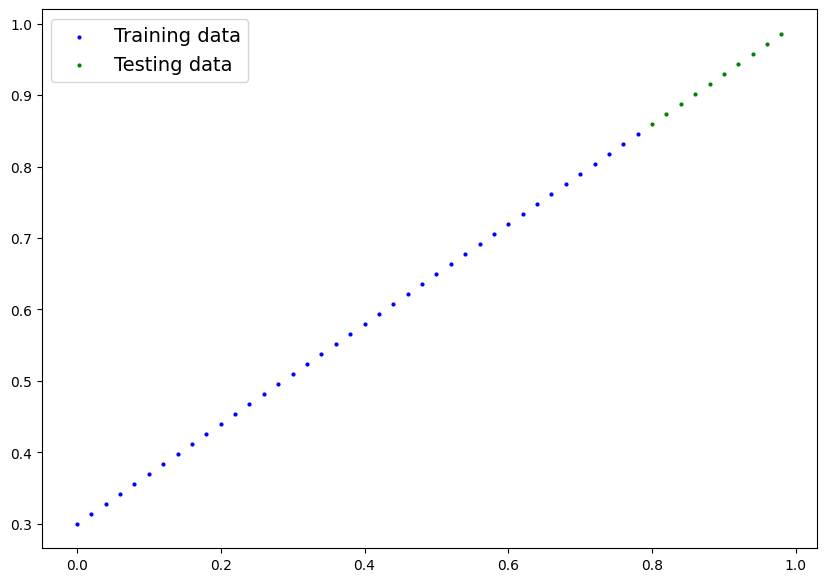

In [30]:
plot_predictions()

###2. Building the first Model

In [31]:
#creating linear regression model class

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights=nn.Parameter(torch.randn(1,requires_grad=True, #start with random values and store the gradient to implement gradient descent
                                          dtype=torch.float))
    self.bias=nn.Parameter(torch.randn(1,requires_grad=True, #start with random values and store gradients to implement gradient descent
                                       dtype=torch.float))

  #forward method to define the computation in the model
  def forward(self, x:torch.Tensor) -> torch.Tensor: #takes in x the input and converts it into a torch tensor
    return self.weights*x + self.bias #returns the linear regression formula

Pytroch Model Building Essential

1. torch.nn - contains all of the buildings for computational graphs
2. torch.nn.Parameter - what parameters should our model try and learn
3. torch.nn.Module - the base class for all neural network modules
4. torch.optim - where the optimizers in PyTorch live they help with gradient descent
5. def forward() - forward prop module for the computation that the model has to do

In [32]:
#create random seed
torch.manual_seed(42)

#create an instance of the model
model_0=LinearRegressionModel()

 #checking the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [33]:
#listing named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

###Making Predictions

We will make predictions using torch.inference_mode()

In [34]:
#make predictions
with torch.inference_mode(): #inference mode turns off the gradient tracking
  y_preds=model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

Use `torch.inference_mode()` to make predictions not for training

In [35]:
y_preds_no_grad=model_0(X_test)
y_preds_no_grad

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [36]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

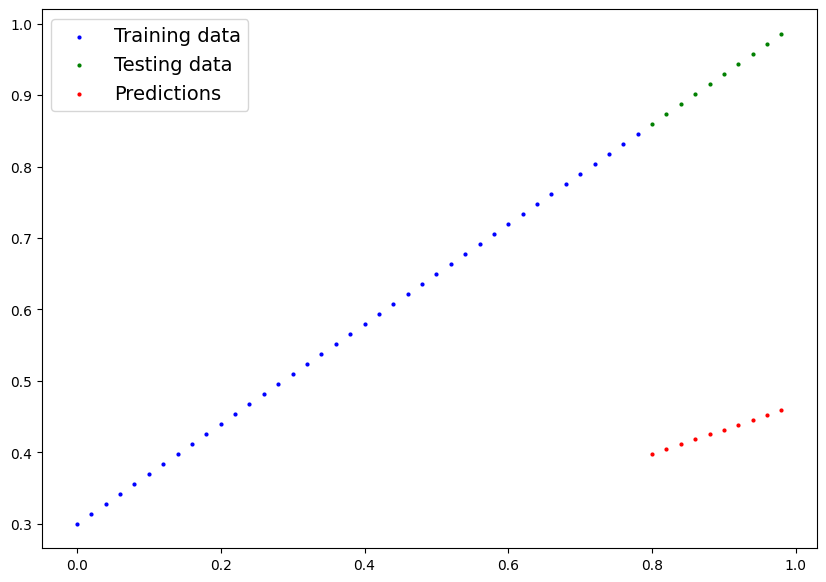

In [37]:
plot_predictions(predictions=y_preds)

###Training the model

For PyTorch we need
1. A training loop
2. A testing loop

In [38]:
#setting up a loss function and optimizer
loss_fn=nn.L1Loss() #mean abs error

optimizer=torch.optim.SGD(params=model_0.parameters(),
                         lr=0.01,
                         momentum=0.9)

###Building a Training Loop

What the loop does:
1. Loop through the data
2. Implement the forward pass
3. Calculate the loss after the forward pass
4. Backward propagation step
5. Optimizer minimizes the loss


In [39]:
torch.manual_seed(42)
epochs=100


epoch_count=[]
training_loss=[]
testing_loss=[]

#1. Looping through the data
for epoch in range(epochs):
  epoch_count.append(epoch)
  #set the model to training mode
  model_0.train()

  #2. forward pass
  y_pred=model_0(X_train)

  #3. calculating loss
  loss=loss_fn(y_pred,y_train)
  training_loss.append(loss)
  #print(f"The loss is : {loss}")
  optimizer.zero_grad() #to prevent accumulation of gradient by optimizer in each epoch

  #4. Backprop
  loss.backward()

  #5. optimizing
  optimizer.step()

  ###testing
  model_0.eval()
  with torch.inference_mode():
    test_pred=model_0(X_test)
    test_loss=loss_fn(test_pred,y_test)
    testing_loss.append(test_loss)

  if epoch%10==0:
    print(f" Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    print(model_0.state_dict())

 Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
 Epoch: 10 | Loss: 0.10313145816326141 | Test Loss: 0.026505161076784134
OrderedDict([('weights', tensor([0.4982])), ('bias', tensor([0.5061]))])
 Epoch: 20 | Loss: 0.06960087269544601 | Test Loss: 0.1943041831254959
OrderedDict([('weights', tensor([0.4652])), ('bias', tensor([0.3147]))])
 Epoch: 30 | Loss: 0.04656733572483063 | Test Loss: 0.027078520506620407
OrderedDict([('weights', tensor([0.5785])), ('bias', tensor([0.3811]))])
 Epoch: 40 | Loss: 0.021285563707351685 | Test Loss: 0.001966828014701605
OrderedDict([('weights', tensor([0.6690])), ('bias', tensor([0.3293]))])
 Epoch: 50 | Loss: 0.015717655420303345 | Test Loss: 0.0101406155154109
OrderedDict([('weights', tensor([0.7189])), ('bias', tensor([0.2730]))])
 Epoch: 60 | Loss: 0.009445277974009514 | Test Loss: 0.02402856945991516
OrderedDict([('weights', tensor([0.7263])), ('bias', te

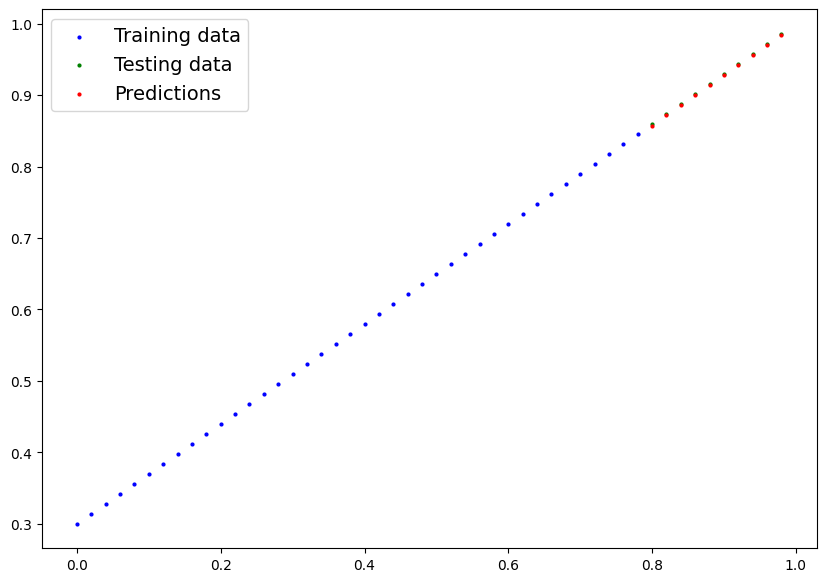

In [40]:
with torch.inference_mode():
  y_preds=model_0(X_test)

plot_predictions(predictions=y_preds)

In [41]:
training_loss,testing_loss


([tensor(0.3129, grad_fn=<MeanBackward0>),
  tensor(0.3014, grad_fn=<MeanBackward0>),
  tensor(0.2795, grad_fn=<MeanBackward0>),
  tensor(0.2482, grad_fn=<MeanBackward0>),
  tensor(0.2086, grad_fn=<MeanBackward0>),
  tensor(0.1614, grad_fn=<MeanBackward0>),
  tensor(0.1079, grad_fn=<MeanBackward0>),
  tensor(0.0654, grad_fn=<MeanBackward0>),
  tensor(0.0509, grad_fn=<MeanBackward0>),
  tensor(0.0679, grad_fn=<MeanBackward0>),
  tensor(0.1031, grad_fn=<MeanBackward0>),
  tensor(0.1274, grad_fn=<MeanBackward0>),
  tensor(0.1377, grad_fn=<MeanBackward0>),
  tensor(0.1355, grad_fn=<MeanBackward0>),
  tensor(0.1220, grad_fn=<MeanBackward0>),
  tensor(0.0983, grad_fn=<MeanBackward0>),
  tensor(0.0675, grad_fn=<MeanBackward0>),
  tensor(0.0483, grad_fn=<MeanBackward0>),
  tensor(0.0465, grad_fn=<MeanBackward0>),
  tensor(0.0565, grad_fn=<MeanBackward0>),
  tensor(0.0696, grad_fn=<MeanBackward0>),
  tensor(0.0784, grad_fn=<MeanBackward0>),
  tensor(0.0792, grad_fn=<MeanBackward0>),
  tensor(0.

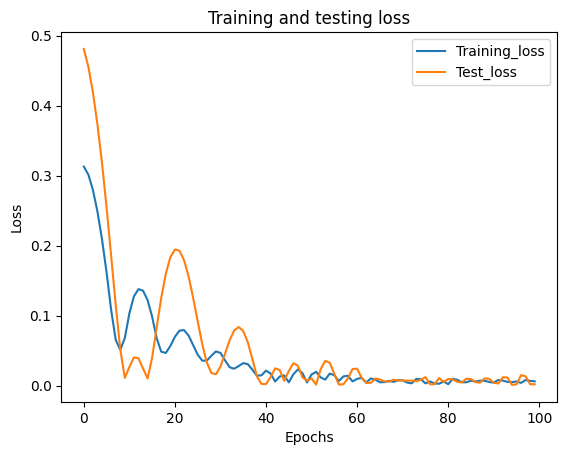

In [42]:
plt.plot(epoch_count,np.array(torch.tensor(training_loss).numpy()),label='Training_loss')
plt.plot(epoch_count,np.array(torch.tensor(testing_loss).numpy()),label='Test_loss')
plt.title("Training and testing loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

###Saving and loading a model
There are 3 main methods involved in saving and loading models in PyTorch

1. `torch.save()` - allows to save the model in python pickle format
2. `torch.load()` - allows to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - loads a model's saved dictionary

In [43]:
#saving a model
from pathlib import Path as path

#creating a directory
MODEL_PATH=path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#create model save path
MODEL_NAME='model_0_linear_regression.pth'
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

#saving model state dict
print(f"saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

saving model to : models/model_0_linear_regression.pth


Since we saved the `state_dict` we will create a new instance of our model class and load the saved `state_dict`

In [44]:
#creating a instance of our model class
loaded_model_0=LinearRegressionModel()

In [45]:
#loading the state_dicts
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [46]:
loaded_model_0.eval()
with torch.inference_mode():
  y_preds=loaded_model_0(X_test)

y_preds

tensor([[0.8575],
        [0.8717],
        [0.8858],
        [0.9000],
        [0.9142],
        [0.9283],
        [0.9425],
        [0.9567],
        [0.9708],
        [0.9850]])

##Putting all the steps together

In [47]:
#creating data
weight=0.84
bias=0.29
start=0
end=2
step=0.015
X=torch.arange(start,end,step).unsqueeze(dim=1)
Y=weight*X+bias

In [48]:
len(X),len(Y)

(134, 134)

In [49]:
train_test_split=int(0.9*(len(X)))
X_train,Y_train=X[:train_test_split],Y[:train_test_split]
X_test,Y_test=X[train_test_split:],Y[train_test_split:]
len(X_train),len(X_test)

(120, 14)

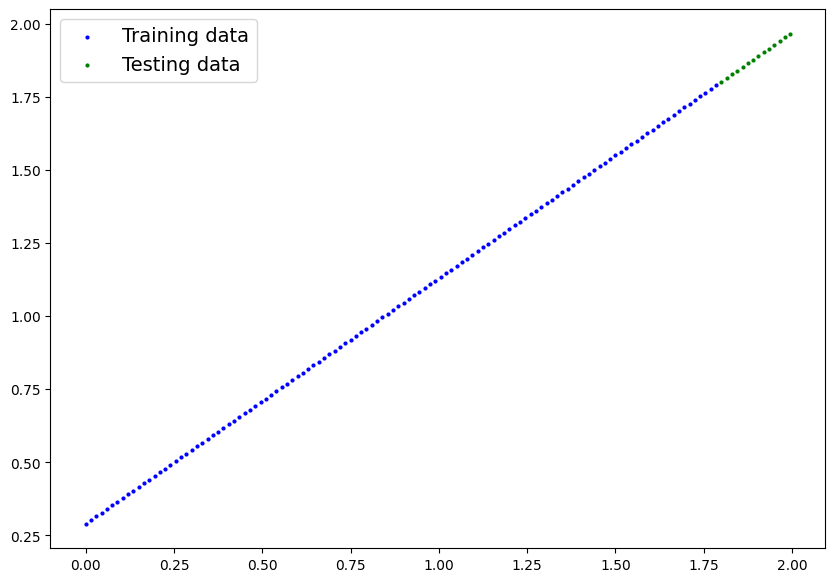

In [50]:
plot_predictions(train_data=X_train,train_labels=Y_train,
                 test_data=X_test,test_labels=Y_test,predictions=None)

In [51]:
class LinearregressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    '''self.weight=nn.Parameter(torch.randn(1,requires_grad=True,
                                        dtype=torch.float))
    self.bias=nn.Parameter(torch.randn(1,requires_grad=True,
                                      dtype=torch.float))'''
    self.linear_layer=nn.Linear(in_features=1,out_features=1,bias=True)
  def forward(self,x:torch.Tensor)->torch.Tensor:
    return self.linear_layer(x)


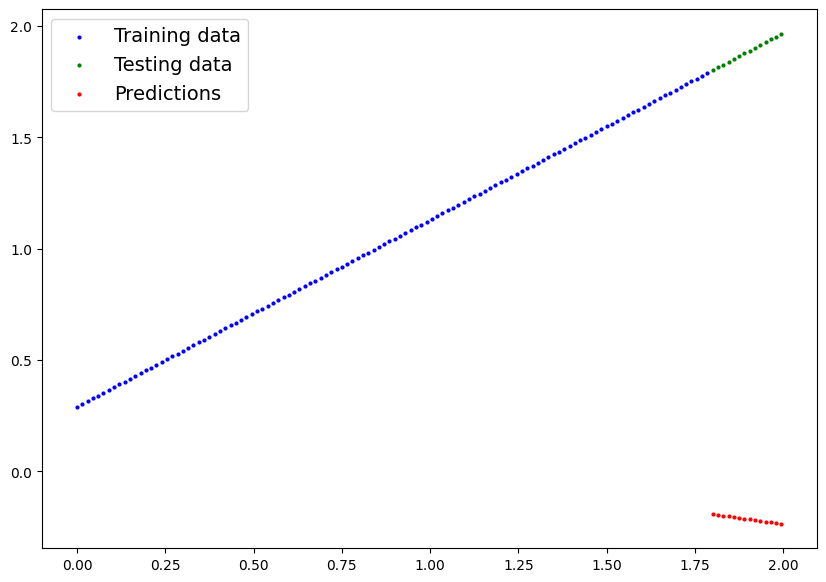

In [52]:
model_recap=LinearregressionModel()

model_recap.eval()
with torch.inference_mode():
  y_preds=model_recap(X_test)

plot_predictions(train_data=X_train,train_labels=Y_train,
                 test_data=X_test,test_labels=Y_test,predictions=y_preds)

In [53]:
loss_fn=nn.L1Loss()

optimizer=torch.optim.SGD(params=model_recap.parameters(),
                          lr=0.01,
                          momentum=0.9)

In [54]:
epochs=500

epoch_count=[]
training_loss=[]
testing_loss=[]

for epoch in range(epochs):
  epoch_count.append(epoch)
  model_recap.train()
  y_preds=model_recap(X_train)
  loss=loss_fn(y_preds,Y_train)
  training_loss.append(loss)
  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  model_recap.eval()
  with torch.inference_mode():
    y_preds=model_recap(X_test)
    test_loss=loss_fn(y_preds,Y_test)
    testing_loss.append(test_loss)

  if epoch%10==0:
    print(f"Epoch  {epoch} | Training loss {loss} | Test loss {test_loss}")
    print(model_recap.state_dict())

Epoch  0 | Training loss 1.033459186553955 | Test loss 2.070923328399658
OrderedDict([('linear_layer.weight', tensor([[-0.2102]])), ('linear_layer.bias', tensor([0.2118]))])
Epoch  10 | Training loss 0.39015036821365356 | Test loss 0.8409934639930725
OrderedDict([('linear_layer.weight', tensor([[0.2075]])), ('linear_layer.bias', tensor([0.6492]))])
Epoch  20 | Training loss 0.33360207080841064 | Test loss 0.024059627205133438
OrderedDict([('linear_layer.weight', tensor([[0.5600]])), ('linear_layer.bias', tensor([0.8448]))])
Epoch  30 | Training loss 0.1911288946866989 | Test loss 0.4887254536151886
OrderedDict([('linear_layer.weight', tensor([[0.4613]])), ('linear_layer.bias', tensor([0.5198]))])
Epoch  40 | Training loss 0.09348748624324799 | Test loss 0.006820738315582275
OrderedDict([('linear_layer.weight', tensor([[0.7444]])), ('linear_layer.bias', tensor([0.4655]))])
Epoch  50 | Training loss 0.0282804723829031 | Test loss 0.07483809441328049
OrderedDict([('linear_layer.weight', t

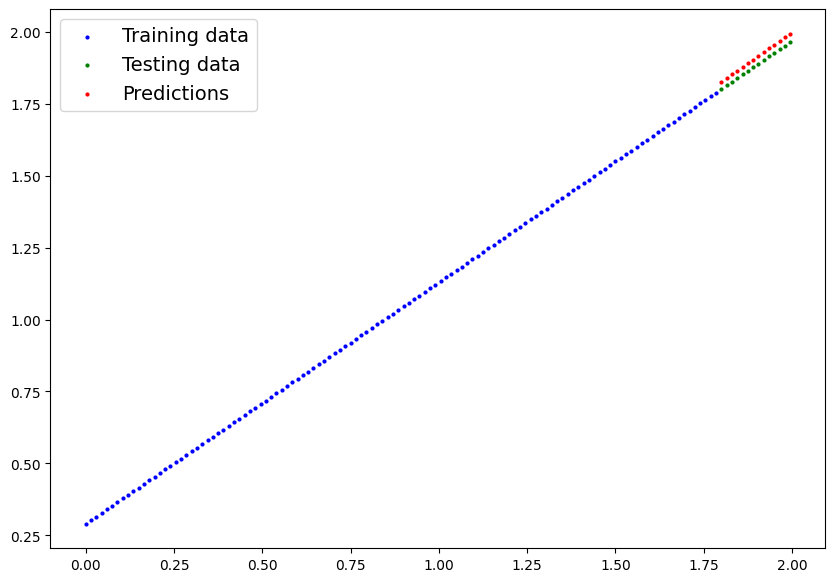

In [55]:
model_recap.eval()
with torch.inference_mode():
  y_preds=model_recap(X_test)

plot_predictions(train_data=X_train,train_labels=Y_train,
                 test_data=X_test,test_labels=Y_test,predictions=y_preds)

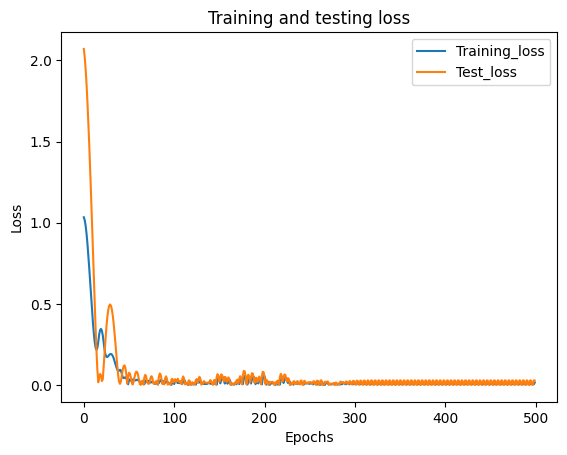

In [56]:
plt.plot(epoch_count,np.array(torch.tensor(training_loss).numpy()),label='Training_loss')
plt.plot(epoch_count,np.array(torch.tensor(testing_loss).numpy()),label='Test_loss')
plt.title("Training and testing loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()